In [69]:
import pandas as pd
import numpy as np
import os
import json
from collections import Counter
import matplotlib.pyplot as plt

In [70]:
# data_dir = './experiments-results/'

# data_dir = './experiments-results/good-res-slmp-seed-0-100'
# data_dir = './experiments-results/good-res-slmp-seed-100-200'
data_dir = './experiments-results/good-res-slmp-seed-0-200-combined'

filenames = os.listdir(data_dir)
filenames[:] = [x for x in filenames if x[-5:] == '.json'] # only select .json files

In [71]:
results = {}
for fn in filenames:
    with open(f'{data_dir}/{fn}', 'r') as jsonfile:
        results[fn] = json.load(jsonfile)

In [72]:
d = {
    'seed': [],
    'p': [],
    'q': [],
    'ts': [],
    'e2e_ebits': [],
    'x_dist': [],
    # 'y_dist': [],
}

for k in results.keys():
    seed = results[k]['params_used']['seed']
    p = results[k]['params_used']['qc_p_loss_init']
    q = results[k]['params_used']['prob_swap_loss']
    # xdist = results[k]['params_used']['x_dist_gte']

    ts_with_ebits = list(Counter(results[k]['results']['time_slot']).keys())
    e2e_per_ts = list(Counter(results[k]['results']['time_slot']).values())
    for idx, ts in enumerate(ts_with_ebits):
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        xdist = int(ts - 1) # NOTE: --1 out of 2-- hacky way -- only applicable to this data where dist = ts-1.
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(e2e_per_ts[idx])
    
    zero_ebits_ts = []
    for ts in range(2, results[k]['params_used']['num_ts'] + 1):
        if ts not in results[k]['results']['time_slot']:
            zero_ebits_ts.append(ts)

    for ts in zero_ebits_ts:
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        xdist = int(ts - 1) # NOTE: --2 out of 2-- hacky way -- only applicable to this data where dist = ts-1.
        d['x_dist'].append(xdist)
        d['ts'].append(ts)
        d['e2e_ebits'].append(0)

df = pd.DataFrame(data=d)

In [73]:
df

,seed,p,q,ts,e2e_ebits,x_dist
0,56,0.55,0.0,2,1,1
1,56,0.55,0.0,4,1,3
2,56,0.55,0.0,6,1,5
3,56,0.55,0.0,3,0,2
4,56,0.55,0.0,5,0,4
...,...,...,...,...,...,...
5995,191,0.40,0.0,8,2,7
5996,191,0.40,0.0,9,2,8
5997,191,0.40,0.0,10,1,9
5998,191,0.40,0.0,11,1,10


In [74]:
p,q = 0.55, 0 
x = 8
df.loc[(df['p'] == p) & (df['q'] == q) & (df['x_dist'] == x)]['seed'].describe()

count    200.000000
mean      99.500000
std       57.879185
min        0.000000
25%       49.750000
50%       99.500000
75%      149.250000
max      199.000000
Name: seed, dtype: float64

In [75]:
data = {
    'p': [],
    'q': [],
    'ebit_per_cycle': [],
    'ebit_per_cycle_stdev': [],
    'x_dist': []
}

# ps = [0.4, 0.55, 0.7]
# qs = [0, 0.1, 0.5]
xs = range(1, 11)
pqs = [(0.55, 0), (0.4, 0.1), (0.4, 0)]

for p, q in pqs:
    for x in xs:
        val = df.loc[(df['p'] == p) & (df['q'] == q) & (df['x_dist'] == x)]['e2e_ebits'].mean()
        stdev = df.loc[(df['p'] == p) & (df['q'] == q) & (df['x_dist'] == x)]['e2e_ebits'].std()
        data['ebit_per_cycle'].append(np.log10(val))
        data['ebit_per_cycle_stdev'].append(stdev)
        data['p'].append(p)
        data['q'].append(q)
        data['x_dist'].append(x)

plotdf = pd.DataFrame(data=data)

In [76]:
def set_size(w, h, ax=None): # from https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Text(0, 0.5, 'log10( ebits/timeslot )')

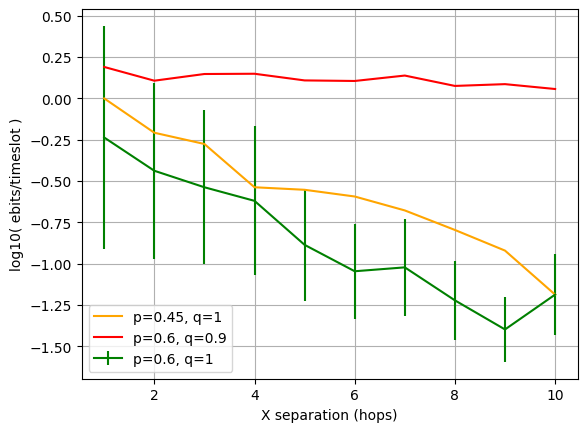

In [82]:
_, ax = plt.subplots()
# set_size(15, 15)
legend = []

p = 0.55
q = 0
legend.append(f"p={round(1-p, 2)}, q={1-q}")
color = 'green'
# plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', yerr = 'ebit_per_cycle_stdev', logy=False, c=color, ax=ax) # with error bars
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax) # without error bars

p = 0.4
q = 0.1
legend.append(f"p={1-p}, q={1-q}")
color = 'orange'
# plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', yerr = 'ebit_per_cycle_stdev', logy=False, c=color, ax=ax) # with error bars
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax) # without error bars

p = 0.4
q = 0
color = 'red'
legend.append(f"p={1-p}, q={1-q}")
# plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', yerr = 'ebit_per_cycle_stdev', logy=False, c=color, ax=ax) # with error bars
plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)].plot(x='x_dist', y='ebit_per_cycle', logy=False, c=color, ax=ax) # without error bars

ax.legend(legend)
ax.grid()
ax.set_xlabel('X separation (hops)')
ax.set_ylabel('log10( ebits/timeslot )')

In [78]:
# plotdf['x_dist'].count()
p,q = 0.55, 0 
x = 8
plotdf.loc[(plotdf['x_dist'] == x) & (plotdf['p'] == p) & (plotdf['q'] == q)].describe()

,p,q,ebit_per_cycle,ebit_per_cycle_stdev,x_dist
count,1.00,1.0,1.000000,1.000000,1.0
mean,0.55,0.0,-1.221849,0.238083,8.0
std,NaN,NaN,NaN,NaN,NaN
min,0.55,0.0,-1.221849,0.238083,8.0
25%,0.55,0.0,-1.221849,0.238083,8.0
50%,0.55,0.0,-1.221849,0.238083,8.0
75%,0.55,0.0,-1.221849,0.238083,8.0
max,0.55,0.0,-1.221849,0.238083,8.0


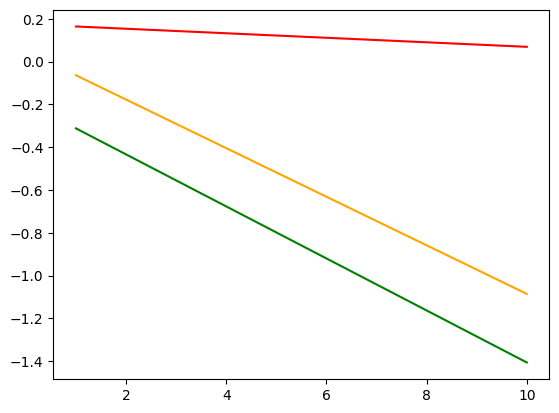

In [79]:
# _, ax = plt.subplots()
legend = []

# green
p = 0.55
q = 0
legend.append(f"p={round(1-p, 2)}, q={1-q}")
color = 'green'
x = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['x_dist']
y = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color=color)

# orange
p = 0.4
q = 0.1
legend.append(f"p={1-p}, q={1-q}")
color = 'orange'
x = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['x_dist']
y = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color=color)

# red
p = 0.4
q = 0
color = 'red'
legend.append(f"p={1-p}, q={1-q}")
x = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['x_dist']
y = plotdf.loc[(plotdf['p'] == p) & (plotdf['q'] == q)]['ebit_per_cycle']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color=color)